#### Hartree-Fock in Pytorch

In [1]:
from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear,HFEnergyFunctionalUnitary,build_fock_matrix,transform_integrals
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00, 11.64it/s]


In [3]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [4]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])

NSMHamiltonian.get_twobody_interaction_optimized(twobody_dict=twobody_matrix)

NSMHamiltonian.get_hamiltonian()

egs,psigs=NSMHamiltonian.get_spectrum(n_states=10)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psigs,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/numba/typed/typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to uint64. Precision may be lost.
  return d[key]


size= 12 6
Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:01<00:00, 1397.39it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-30.29539461 -26.88369692 -19.0041005  -15.86699708 -15.31298892
 -14.49860676 -13.61172347 -13.41558684 -12.80630663 -12.62779145]
total_m= [0.00000000e+00 0.00000000e+00 1.51788304e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.77555756e-17 5.20417043e-18
 1.38777878e-17 2.08166817e-17]
dimension= 51


Hartree-Fock method

In [5]:
hf = HFEnergyFunctionalUnitary(torch.diag(torch.tensor(SPS.energies)), twobody_matrix, nparticles_a+nparticles_b)
opt = torch.optim.Adam(hf.parameters(), lr=1e-2)

v_ext=torch.diag(torch.tensor(SPS.energies)).detach().numpy()

for it in range(1000):
    opt.zero_grad()
    E = hf()
    E.backward()
    opt.step()

    if it % 50 == 0:
        print(it, E.item())

0 -4.273993686823161
50 -14.059738728199115
100 -22.633802108379992
150 -25.441126611015417
200 -25.684752003434443
250 -25.688933678954406
300 -25.68903156823395
350 -25.689032357023365
400 -25.689032357565228
450 -25.68903235757841
500 -25.68903235757844
550 -25.68903235757844
600 -25.689032357578434
650 -25.68903235757842
700 -25.689032357578437
750 -25.689032357578444
800 -25.689032357578473
850 -25.689032357578462
900 -25.689032357578448
950 -25.689032357578455


In [6]:
v_matrix=np.zeros((size_a+size_b,size_a+size_b,size_a+size_b,size_a+size_b))
for key in twobody_matrix.keys():
    a,b,c,d=key
    v_matrix[a,b,c,d]=twobody_matrix[key]

fock_operator=build_fock_matrix(h_mat=v_ext,V_tensor=v_matrix,rho=hf.rho)

eps, U_can = np.linalg.eigh(fock_operator)   # columns of U_can are eigenvectors
print(eps)
# U_can maps canonical index -> old basis index as columns; we want U matrix with rows=new index, cols=old basis
# Here U_can has shape (M,M) as columns are eigenvectors in old basis; define U = U_can.T
U = U_can.T.copy()
# Transform integrals
h_p, V_p, Vbar_p = transform_integrals(U, v_ext, v_matrix)

[-6.42493241 -6.42493241 -6.42493241 -6.42493241 -0.6498448  -0.6498448
 -0.6498448  -0.6498448   1.06353834  1.06353834  1.06353834  1.06353834]


[1.79000695 1.79000695 1.79000695 1.79000695 1.63       1.63
 1.63       1.63       2.10999305 2.10999305 2.10999305 2.10999305]


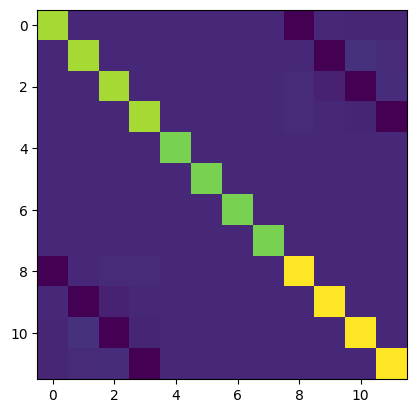

In [16]:
new_energies=np.diag(h_p)
print(new_energies)
plt.imshow(h_p)
plt.show()

new_twobody_matrix={}
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        for c in range(size_a+size_b):
            for d in range(size_a+size_b):
                if np.abs(V_p[a,b,c,d])>=10**-7:
                    new_twobody_matrix[(a,b,c,d)]=V_p[a,b,c,d]

In [17]:
print((new_twobody_matrix))

{(0, 1, 0, 1): np.float64(-4.313768765690309), (0, 1, 0, 2): np.float64(-0.27529118016093845), (0, 1, 0, 3): np.float64(-0.10751465674425442), (0, 1, 0, 4): np.float64(-0.000989494611542011), (0, 1, 0, 5): np.float64(0.07323225428271533), (0, 1, 0, 6): np.float64(-0.00514618733280946), (0, 1, 0, 7): np.float64(-0.006925241465057347), (0, 1, 0, 8): np.float64(0.004151511107157309), (0, 1, 0, 9): np.float64(0.4336271791379848), (0, 1, 0, 10): np.float64(-0.12396341067720827), (0, 1, 0, 11): np.float64(-0.09292195806801604), (0, 1, 1, 0): np.float64(4.313768765690309), (0, 1, 1, 2): np.float64(-0.06511251623117846), (0, 1, 1, 3): np.float64(-0.4531676604470132), (0, 1, 1, 4): np.float64(0.007530584096109056), (0, 1, 1, 5): np.float64(-0.0858919659413573), (0, 1, 1, 6): np.float64(0.04745456397205521), (0, 1, 1, 7): np.float64(-0.0034070737850839567), (0, 1, 1, 8): np.float64(-0.4456137322335464), (0, 1, 1, 9): np.float64(-0.00787026867605566), (0, 1, 1, 10): np.float64(-0.0154182458054824

In [22]:
NSMFockHamiltonian=FermiHubbardHamiltonian(size_a=size_a+size_b,size_b=0,nparticles_a=nparticles_a+nparticles_b,nparticles_b=0)
# one body term:
one_body_term=0.
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        one_body_term+=h_p[a,b]*NSMFockHamiltonian.adag_a_matrix_optimized(a,b)


NSMFockHamiltonian.get_twobody_interaction_optimized(new_twobody_matrix)
NSMFockHamiltonian.get_hamiltonian()
NSMFockHamiltonian.hamiltonian+=one_body_term
egs,psigshf=NSMFockHamiltonian.get_spectrum(10)
print(egs)

Building two-body operator with 15888 terms...


100%|██████████| 15888/15888 [00:01<00:00, 13004.16it/s]

✅ Two-body operator built: shape=(495, 495), nnz=94055
[-30.29539461 -26.88369692 -26.88369692 -26.88369692 -26.88369692
 -26.88369692 -19.0041005  -19.0041005  -19.0041005  -19.0041005 ]


In [25]:
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp

QPC=QuasiParticlesConverterOnlynnpp()
QPC.initialize_shell(state_encoding=SPS.state_encoding)
QPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis)


QPCHF=QuasiParticlesConverterOnlynnpp()
QPCHF.initialize_shell(state_encoding=SPS.state_encoding)
QPCHF.get_the_basis_matrix_transformation(NSMFockHamiltonian.basis)

new_couples=[]
for i in range(0,size_a+size_b,2):
    new_couples.append([i,i+1])
    
    
QPCHF.couples=new_couples






In [26]:
print(QPC.quasiparticle_basis.shape)
hamiltonian_Q=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
egsQ,psi_Q=eigsh(hamiltonian_Q,k=8,which='SA')

hamiltonian_QHF=QPCHF.particles2quasiparticles @ NSMFockHamiltonian.hamiltonian @ QPCHF.particles2quasiparticles.T
egsQnp,psi_Qnp=eigsh(hamiltonian_QHF,k=10,which='SA')

print(egsQnp,egsQ)






print('\n')

#print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
fs=[]
for i in range(egsQnp.shape[0]):
    psi_Qnp2particle=QPCHF.particles2quasiparticles.T @ psi_Qnp[:,i]
    psi_Qnp2particle/=np.linalg.norm(psi_Qnp2particle)
    print(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))#,j_values[i])
    fs.append(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))
print('\n')
print(np.sum(fs),'\n')
fs=[]
for i in range(egsQ.shape[0]):
    psi_Q2particle=QPC.particles2quasiparticles.T @ psi_Q[:,i]
    psi_Q2particle/=np.linalg.norm(psi_Q2particle)
    
    print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))#,j_values[0])
    fs.append(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
print('\n')
print(np.sum(fs))


(9, 6)
[-25.69837194 -12.15337558  -9.90063329  -9.33229066  -8.69891934
  -8.07284769  -8.01111713  -7.24906737  -6.60239169  -6.19936059] [-20.3041178  -17.43478828 -12.52467658 -10.67469442  -6.97037031
  -5.557375    -1.44209672  -0.34163842]


0.20546686035192743
8.581934191588574e-05
0.00010279078739673955
0.0012805144434182268
9.378505384267029e-07
0.00014529967041207136
0.0005066891273389074
0.00233792868466564
3.218406827316753e-05
0.003985784905590889


0.2139448092314774 

0.5758878400309743
1.472845443320512e-31
1.0944159994793368e-32
0.009593520332546514
0.0008179919153660388
4.187675296295723e-33
2.010387505438113e-33
1.5182643564331498e-33


0.5862993522788869
